## Preprocessing Liu Cell Lines

Link to paper here

## Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu

In [2]:
# Reading R files
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
readRDS = robjects.r['readRDS']

## Load RNA

In [3]:
rna = readRDS('../datasets/Liu/original/CellLines_RNAseqCounts.RDS')
rna = ad.AnnData(rna.T)
rna

AnnData object with n_obs × n_vars = 206 × 49073

## Load ATAC

In [4]:
atac = readRDS('../datasets/Liu/original/CellLines_ATACseqCounts.RDS')
atac = ad.AnnData(atac.T)
atac

AnnData object with n_obs × n_vars = 206 × 207202

## Load metadata

In [5]:
meta = readRDS('../datasets/Liu/original/CellLines_metadata.RDS')
meta

,sample.rna,sample.atac,Total.Read.Pairs,Mapped.read.pairs,chrM.read.pairs,Unique.Flagments,Usable.Flagments,Flagments.in.peaks,Rate.of.Flagments.in.peaks...,lane.atac,...,unique.mapped.gene.,Multiple.mapped.gene.,Gene.mapped.rate...,Gene.number.FPKM..1.,ERCC.number,lane.rna.y,batch.rna.y,celltype,quality.pass,Type
1,HCT_CL100049490_L01_10,HCT_CL100050215_L01_10,5652832,2142410,308401,288574,287830,43823,15.225307,CL100050215_L01,...,2428210,6764665,79.13,12728,57,CL100049490_L01,scCAT_20171127_HCT_R1_1.Summary.xls,HCT,1,HCT
2,HCT_CL100049490_L01_14,HCT_CL100050215_L01_14,7927709,2420888,227655,168073,167591,47288,28.216312,CL100050215_L01,...,2454685,6494370,74.84,12813,55,CL100049490_L01,scCAT_20171127_HCT_R1_1.Summary.xls,HCT,1,HCT
3,HCT_CL100049490_L01_15,HCT_CL100050215_L01_15,8299477,3220612,261155,295228,294344,60415,20.525304,CL100050215_L01,...,3394474,9403818,77.33,13510,55,CL100049490_L01,scCAT_20171127_HCT_R1_1.Summary.xls,HCT,1,HCT
4,HCT_CL100049490_L01_16,HCT_CL100050215_L01_16,7949453,2976918,181194,203974,203278,46737,22.991667,CL100050215_L01,...,3689905,8437816,76.62,11754,55,CL100049490_L01,scCAT_20171127_HCT_R1_1.Summary.xls,HCT,1,HCT
5,HCT_CL100049490_L01_19,HCT_CL100050215_L01_19,11619678,4256602,461415,440250,439264,92790,21.123971,CL100050215_L01,...,2606176,6962609,79.86,13875,55,CL100049490_L01,scCAT_20171127_HCT_R1_1.Summary.xls,HCT,1,HCT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,K562_CL100050926_L02_86,K562_CL100050285_L01_86,6389431,2344510,348776,147524,147062,45558,30.978771,CL100050285_L01,...,0,0,0.00,8320,15,CL100050926_L02,scCAT_20171120_K562_R2_2.Summary.xls,K562,1,K562
203,K562_CL100050926_L02_87,K562_CL100050285_L01_87,7824263,3202200,403837,343968,342965,71415,20.822824,CL100050285_L01,...,1219763,2037511,53.42,10581,53,CL100050926_L02,scCAT_20171120_K562_R2_2.Summary.xls,K562,1,K562
204,K562_CL100050926_L02_88,K562_CL100050285_L01_88,8856414,3596359,293302,242555,242173,67996,28.077449,CL100050285_L01,...,1536600,2698514,52.65,10177,59,CL100050926_L02,scCAT_20171120_K562_R2_2.Summary.xls,K562,1,K562
205,K562_CL100050926_L02_92,K562_CL100050285_L01_92,8844021,3415434,317032,162210,161744,50794,31.403947,CL100050285_L01,...,1711834,3049732,53.16,10684,53,CL100050926_L02,scCAT_20171120_K562_R2_2.Summary.xls,K562,1,K562


## Annotate

In [6]:
# Cell types on RNA
rna.obs['celltype'] = meta.set_index('sample.rna')['celltype']

In [7]:
# Cell types on ATAC
atac.obs['celltype'] = meta.set_index('sample.atac')['celltype']

In [8]:
# Same cell names in both modalities
atac.obs['sample.rna'] = meta.set_index('sample.atac')['sample.rna']
atac.obs.set_index('sample.rna', inplace=True)

## Preprocess RNA

In [9]:
# Mitochondrial QC metrics
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'celltype' as categorical


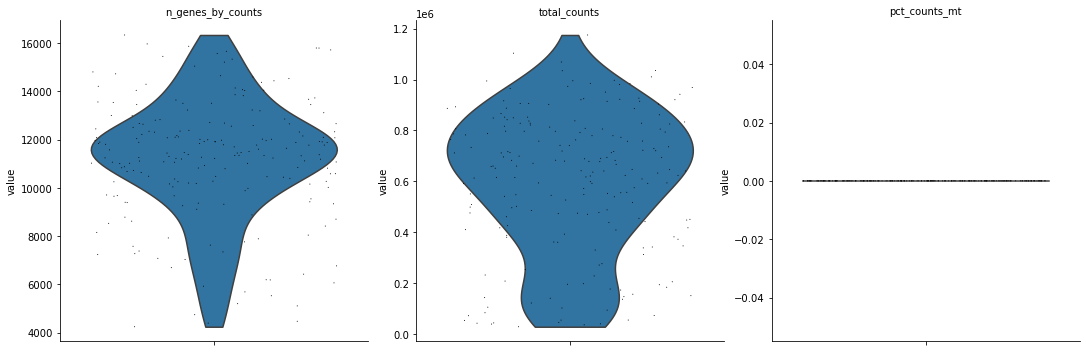

In [10]:
# Violin plot of QC metrics
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [11]:
# Filter genes
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 10)

In [12]:
# Per-cell normalization
sc.pp.normalize_total(rna, target_sum=1e4)

In [13]:
# Log-normalize
sc.pp.log1p(rna)

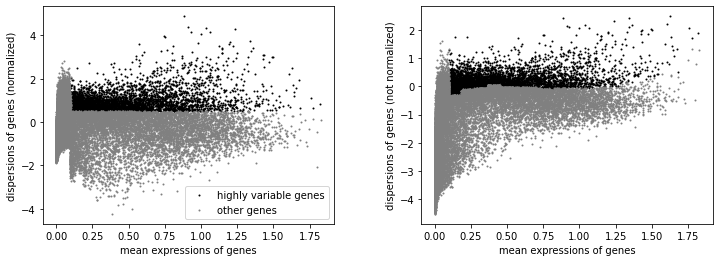

3861

In [14]:
# Highly variable genes
sc.pp.highly_variable_genes(rna, min_mean=0.1, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna)
np.sum(rna.var.highly_variable)

## Preprocess ATAC

In [15]:
# Compute QC metrics
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

In [16]:
# Filter genes
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)

... storing 'celltype' as categorical


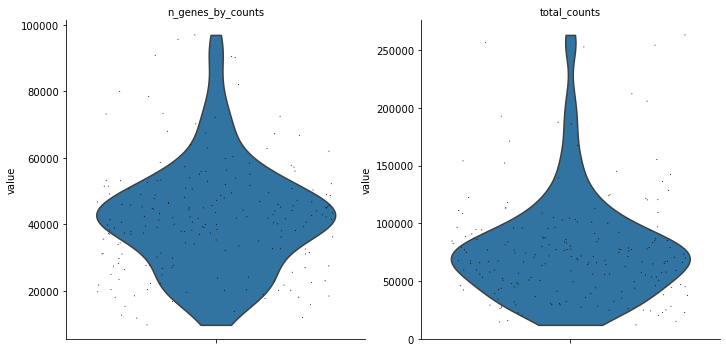

In [17]:
# Violin again
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

In [18]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1)
#sc.pp.log1p(atac)

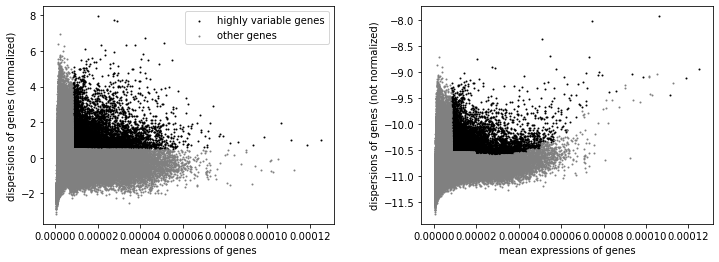

7567

In [19]:
sc.pp.highly_variable_genes(atac, min_mean=8e-6, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(atac)
np.sum(atac.var.highly_variable)

## Package into Muon object

In [20]:
rna = rna[~rna.obs['celltype'].isna()].copy()
atac = atac[~atac.obs['celltype'].isna()].copy()

In [21]:
# Create MuData object with rna and atac
mdata = mu.MuData({'rna': rna, 'atac': atac})

In [22]:
mu.pp.intersect_obs(mdata)

In [23]:
mdata

MuData object with n_obs × n_vars = 206 × 209316
  var:	'dispersions', 'dispersions_norm', 'highly_variable', 'mean_counts', 'means', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	206 x 21875
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    atac:	206 x 187441
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'

In [24]:
mdata.write_h5mu('../datasets/Liu/preprocessed/liu.h5mu.gz', compression='gzip')